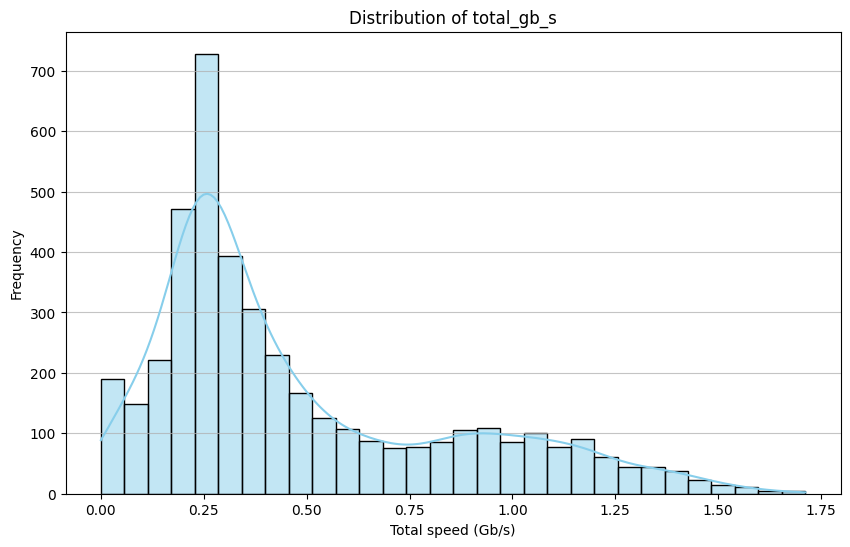

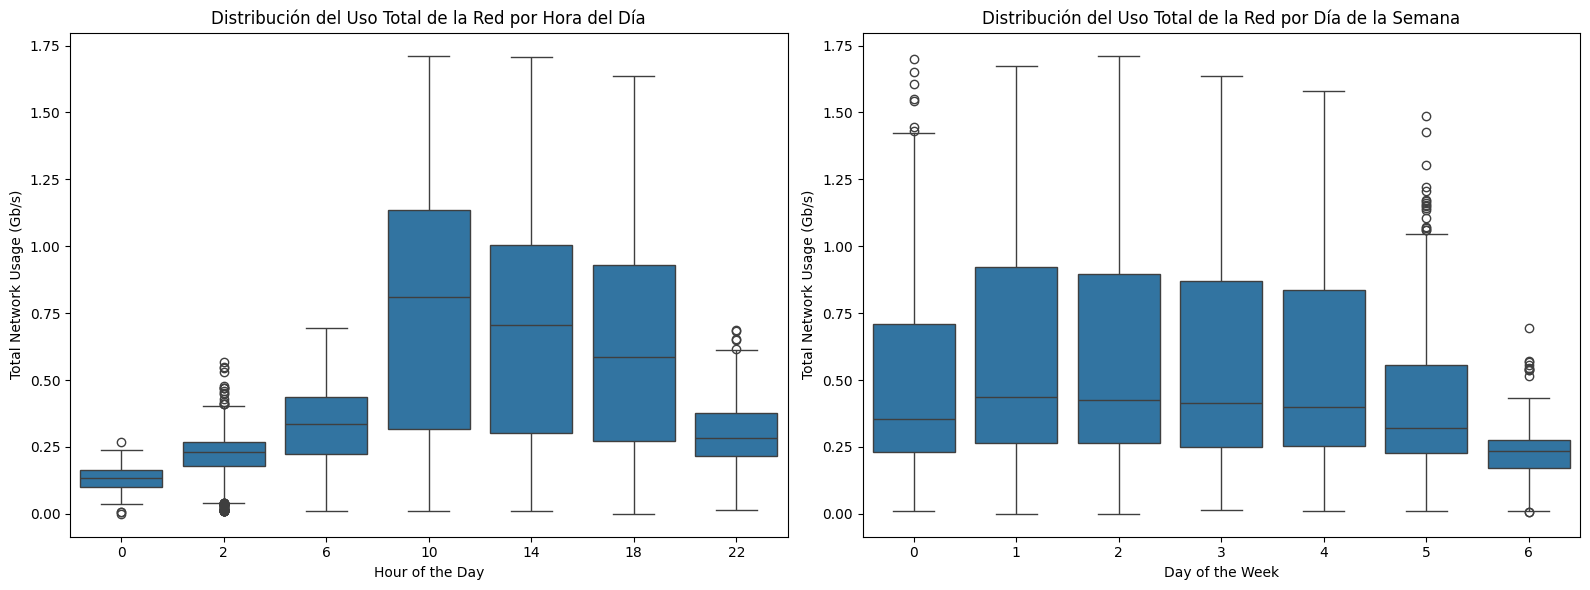

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file
        :param file_path: path to the csv file
        :return: a pandas dataframe
        """
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        df['time'] = pd.to_datetime(df['time'])
        df['download_gb_s'] = df['download_b/s'] / (10**9)
        df['total_gb_s'] = df['total_b/s'] / (10**9)
        
        df.sort_values('time', inplace=True)  # Ensure data is ordered by time
        df.index = df['time']  # Set the time as the index
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
        df['day_of_month'] = df.index.day  # Extract day of the month (1-31)
        df['month'] = df.index.month

        col_holidays = holidays.Colombia()
        df['is_holiday'] = df['time'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in col_holidays else 0)  # Check if the date is a holiday

        return df

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame, columns: list):
        """
        Scale the specified columns of the dataframe
        """
        scaler = MinMaxScaler(feature_range=(0, 1))
        df_scaled = df.copy()
        df_scaled[columns] = scaler.fit_transform(df[columns])
        return df_scaled, scaler
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i]['time'])  # Store the timestamp
        return np.array(X), np.array(y), np.array(timestamps)

# Load and preprocess data
file_path = './outup/usage_over_time.csv'
df = NET_LSTM.load_and_preprocess_data(file_path)

# Scale the data
columns_to_scale = ['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']
df_scaled, scaler = NET_LSTM.scale_data(df, columns_to_scale)  # Scale the data

# Visualize the distribution of the total speed (Gb/s)
NET_LSTM.plot_distribution(df, 'total_gb_s')  # Plot histogram
# df = pd.get_dummies(df, columns=['hour', 'day_of_week', 'day_of_month', 'month'])
# df.head()

plt.figure(figsize=(16, 6))
# Graphical representation of the distribution of the total network usage by hour of the day
plt.subplot(1, 2, 1)
sns.boxplot(x='hour', y='total_gb_s', data=df,)
plt.title('Distribución del Uso Total de la Red por Hora del Día')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Network Usage (Gb/s)')

# Graphical representation of the distribution of the total network usage by day of the week
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='total_gb_s', data=df)
plt.title('Distribución del Uso Total de la Red por Día de la Semana')
plt.xlabel('Day of the Week')
plt.ylabel('Total Network Usage (Gb/s)')

plt.tight_layout()
plt.show()

In [2]:
required_cols = ['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']
df = df[required_cols]
df.head()

df.isna().sum()
df = df.ffill()  # Fill missing values

# scaled_features = NET_LSTM.scale_data(df)  # Scale the data
n_steps = 42  # Number of time steps based on 7 days (24h/4h = 6 * 7d = 42)
# Create sequences (Divide the data into input and target)
X, y, timestamps = NET_LSTM.create_sequences_with_timestamps(df_scaled, n_steps, 'total_gb_s')

train_size = int(len(X) * 0.7)  # 70% train, 20% validation, 10% test
val_size = int(len(X) * 0.2)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
timestamps_test = timestamps[train_size + val_size:] # Store the timestamps for the test set

# X_train.shape, X_val.shape, X_test.shape
# y_train.shape, y_val.shape, y_test.shape

n_features = X_train.shape[2]  # Number of features

In [3]:
n_features = X_train.shape[2]  # Number of features

# Build the model
model = Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

## Define callbacks

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model1.keras',
    monitor='val_loss',
    save_best_only=True,
    # save_weights_only=False,
    # mode='min'
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 42, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,451 (286.92 KB)

 Trainable params: 73,451 (286.92 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0495 - val_loss: 0.0546
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0359 - val_loss: 0.0511
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0336 - val_loss: 0.0482
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0310 - val_loss: 0.0373
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0241 - val_loss: 0.0200
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0163 - val_loss: 0.0194
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0134 - val_loss: 0.0180
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0140 - val_loss: 0.0148
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0119 - val_loss: 0.0140
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


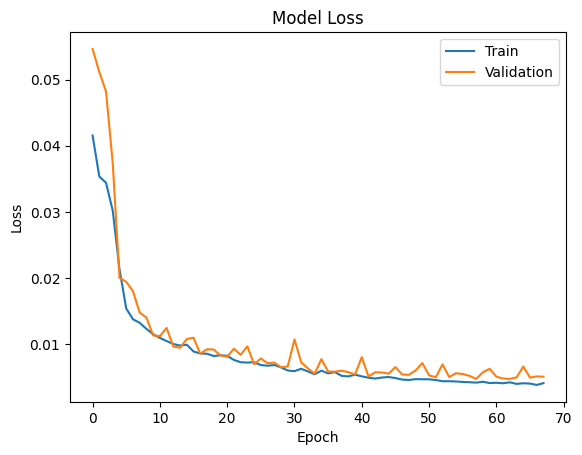

Mean Absolute Error 0.04587920102928067
Mean Squared Error 0.0039280769609379
Root Mean Squared Error 0.06267437244151632


In [5]:
predictions = model.predict(X_test)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

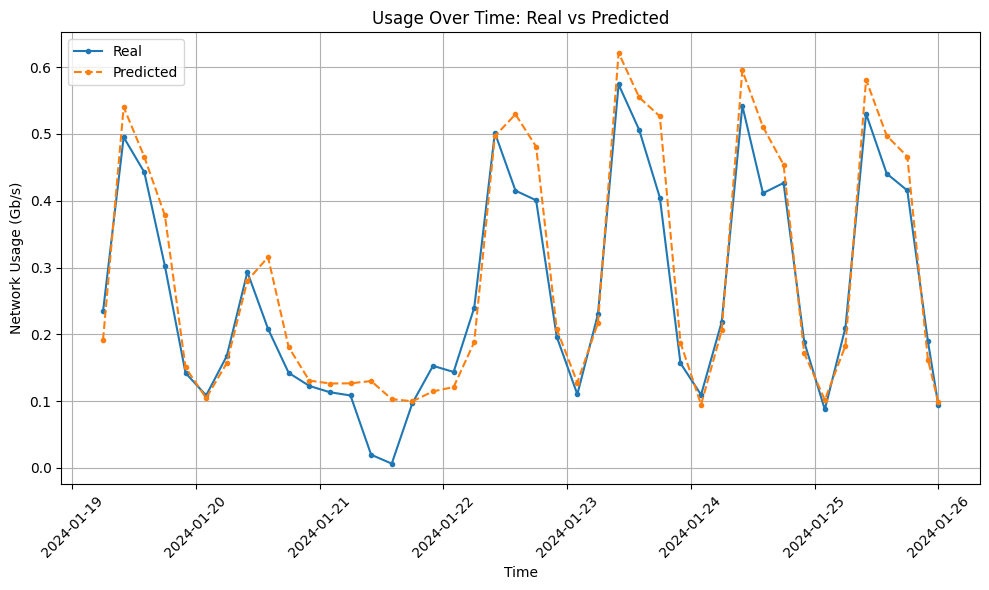

In [6]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-42:], y_test[-42:], label='Real', marker='.')
plt.plot(timestamps_test[-42:], predictions[-42:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

In [7]:
model_2 = Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 42, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,451 (286.92 KB)

 Trainable params: 73,451 (286.92 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model_2.compile(optimizer='adam', loss='mse')
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 42, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 42, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,451 (286.92 KB)

 Trainable params: 73,451 (286.92 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history_1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

test_loss_1 = model_1.evaluate(X_test, y_test)
print(f'Test Loss 1: {test_loss_1}')

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0036 - val_loss: 0.0055
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0039 - val_loss: 0.0063
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

NameError: name 'model_1' is not defined

In [10]:
# Train the model
history_1 = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

test_loss_1 = model_2.evaluate(X_test, y_test)
print(f'Test Loss 1: {test_loss_1}')

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0500 - val_loss: 0.0576
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0368 - val_loss: 0.0503
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0355 - val_loss: 0.0493
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0326 - val_loss: 0.0478
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0310 - val_loss: 0.0395
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0257 - val_loss: 0.0267
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0190 - val_loss: 0.0184
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0167 - val_loss: 0.0208
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0141 - val_loss: 0.0155
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0128 - val_loss: 0.0134
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138
Test Loss 1: 0.0123441806063056


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


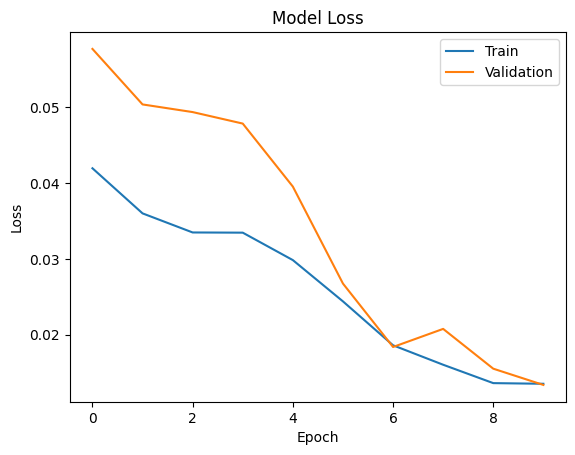

Mean Absolute Error 0.04954514193714407
Mean Squared Error 0.004595750390240394
Root Mean Squared Error 0.06779196405356902


In [11]:
predictions_2 = model.predict(X_test)

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate and pritn error metrics
mae_2 = mean_absolute_error(y_test, predictions_2)
mse_2 = mean_squared_error(y_test, predictions_2)
rmse_2 = np.sqrt(mse_2)  # Correct RMSE calculation

print("Mean Absolute Error", mae_2)
print("Mean Squared Error", mse_2)
print("Root Mean Squared Error", rmse_2)

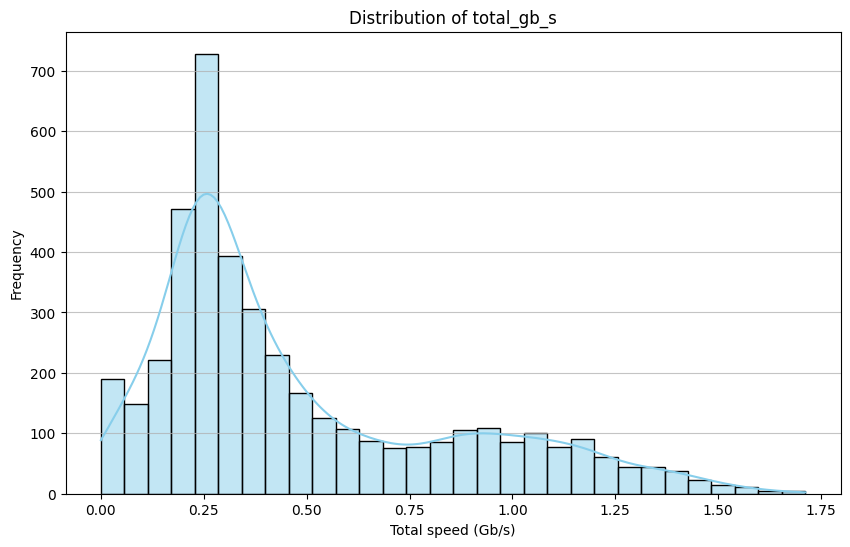

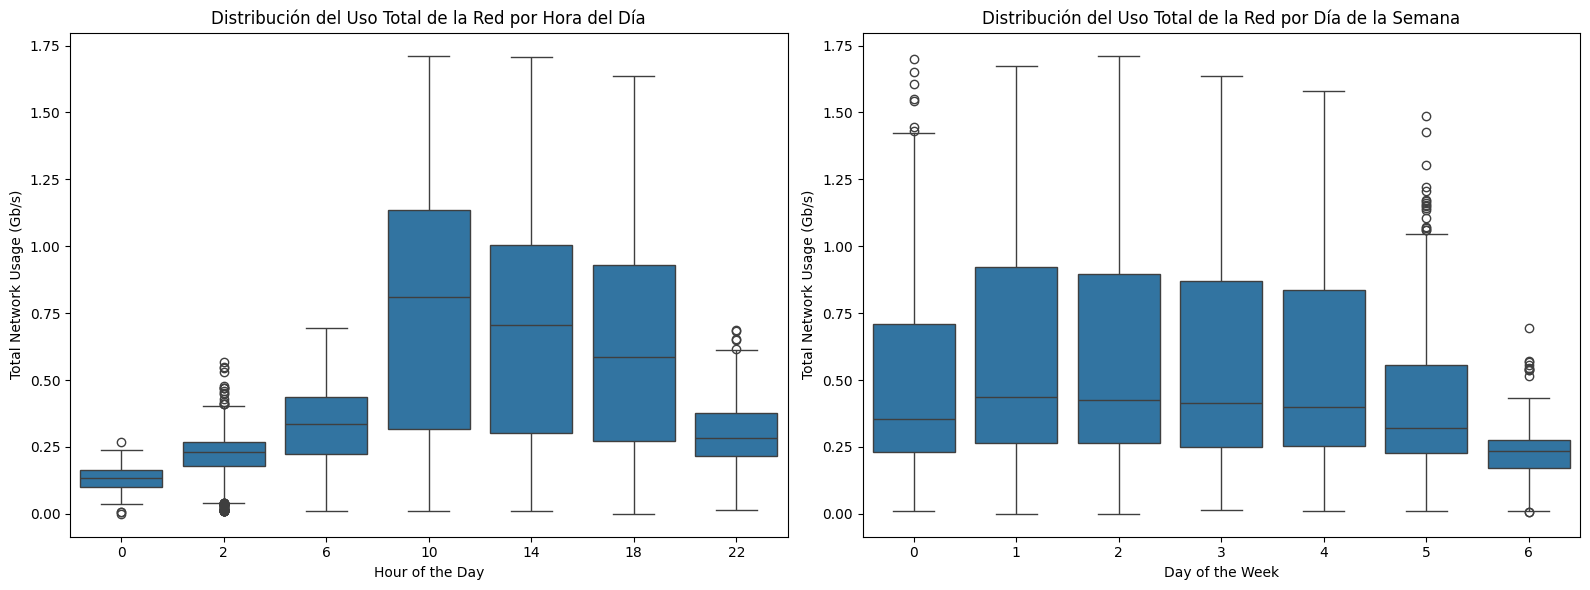

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 42, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,451 (286.92 KB)

 Trainable params: 73,451 (286.92 KB)

 Non-trainable params: 0 (0.00 B)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file
        :param file_path: path to the csv file
        :return: a pandas dataframe
        """
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        df['time'] = pd.to_datetime(df['time'])
        df['download_gb_s'] = df['download_b/s'] / (10**9)
        df['total_gb_s'] = df['total_b/s'] / (10**9)
        
        df.sort_values('time', inplace=True)  # Ensure data is ordered by time
        df.index = df['time']  # Set the time as the index
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
        df['day_of_month'] = df.index.day  # Extract day of the month (1-31)
        df['month'] = df.index.month

        col_holidays = holidays.Colombia()
        df['is_holiday'] = df['time'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in col_holidays else 0)  # Check if the date is a holiday

        return df

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame, columns: list):
        """
        Scale the specified columns of the dataframe
        """
        scaler = MinMaxScaler(feature_range=(0, 1))
        df_scaled = df.copy()
        df_scaled[columns] = scaler.fit_transform(df[columns])
        return df_scaled, scaler
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i]['time'])  # Store the timestamp
        return np.array(X), np.array(y), np.array(timestamps)

# Load and preprocess data
file_path = './outup/usage_over_time.csv'
df = NET_LSTM.load_and_preprocess_data(file_path)

# Scale the data
columns_to_scale = ['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']
df_scaled, scaler = NET_LSTM.scale_data(df, columns_to_scale)  # Scale the data

# Visualize the distribution of the total speed (Gb/s)
NET_LSTM.plot_distribution(df, 'total_gb_s')  # Plot histogram
# df = pd.get_dummies(df, columns=['hour', 'day_of_week', 'day_of_month', 'month'])
# df.head()

plt.figure(figsize=(16, 6))
# Graphical representation of the distribution of the total network usage by hour of the day
plt.subplot(1, 2, 1)
sns.boxplot(x='hour', y='total_gb_s', data=df,)
plt.title('Distribución del Uso Total de la Red por Hora del Día')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Network Usage (Gb/s)')

# Graphical representation of the distribution of the total network usage by day of the week
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='total_gb_s', data=df)
plt.title('Distribución del Uso Total de la Red por Día de la Semana')
plt.xlabel('Day of the Week')
plt.ylabel('Total Network Usage (Gb/s)')

plt.tight_layout()
plt.show()


required_cols = ['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']
df = df[required_cols]
df.head()

df.isna().sum()
df = df.ffill()  # Fill missing values

# scaled_features = NET_LSTM.scale_data(df)  # Scale the data
n_steps = 42  # Number of time steps based on 7 days (24h/4h = 6 * 7d = 42)
# Create sequences (Divide the data into input and target)
X, y, timestamps = NET_LSTM.create_sequences_with_timestamps(df_scaled, n_steps, 'total_gb_s')

train_size = int(len(X) * 0.7)  # 70% train, 20% validation, 10% test
val_size = int(len(X) * 0.2)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
timestamps_test = timestamps[train_size + val_size:] # Store the timestamps for the test set

# X_train.shape, X_val.shape, X_test.shape
# y_train.shape, y_val.shape, y_test.shape

n_features = X_train.shape[2]  # Number of features

# Build the model
model = Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0499 - val_loss: 0.0529
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0364 - val_loss: 0.0521
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0338 - val_loss: 0.0495
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0334 - val_loss: 0.0453
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0304 - val_loss: 0.0396
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0252 - val_loss: 0.0216
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0161 - val_loss: 0.0153
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0144 - val_loss: 0.0171
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0138 - val_loss: 0.0132
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

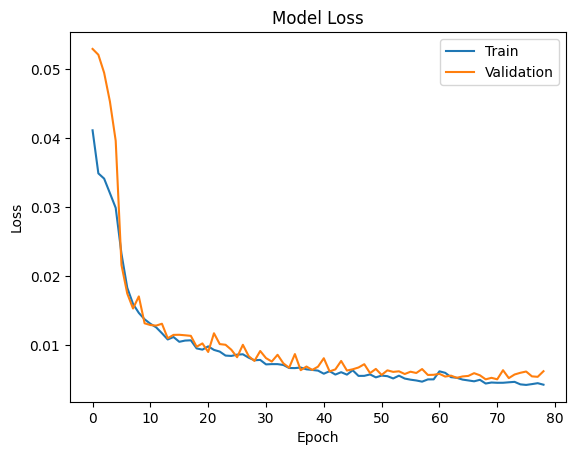

Mean Absolute Error 0.041132717365509296
Mean Squared Error 0.002955951903648877
Root Mean Squared Error 0.05436866656125454


In [2]:

## Define callbacks

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model1.keras',
    monitor='val_loss',
    save_best_only=True,
    # save_weights_only=False,
    # mode='min'
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

predictions = model.predict(X_test)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 0.0060
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - val_loss: 0.0058
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042 - val_loss: 0.0076
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - val_loss: 0.0057
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.002

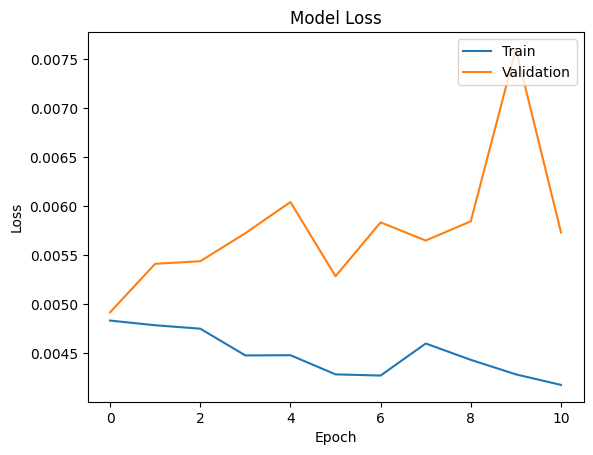

Mean Absolute Error 0.03797591065261607
Mean Squared Error 0.002753090731142561
Root Mean Squared Error 0.052469903098276836


In [3]:

## Define callbacks

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model1.keras',
    monitor='val_loss',
    save_best_only=True,
    # save_weights_only=False,
    # mode='min'
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

predictions = model.predict(X_test)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 0.0063
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - val_loss: 0.0058
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - val_loss: 0.0063
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Test Loss: 0.0027896997053176165
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


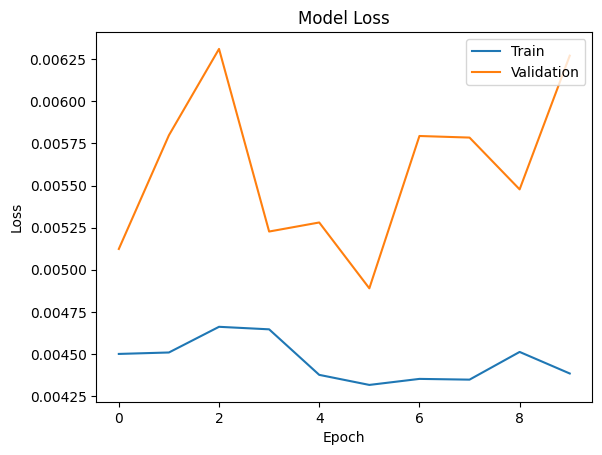

Mean Absolute Error 0.03829393088119327
Mean Squared Error 0.002852467094429302
Root Mean Squared Error 0.05340849271819326


In [4]:

## Define callbacks

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model1.keras',
    monitor='val_loss',
    save_best_only=True,
    # save_weights_only=False,
    # mode='min'
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

predictions = model.predict(X_test)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_loss: 0.0056
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

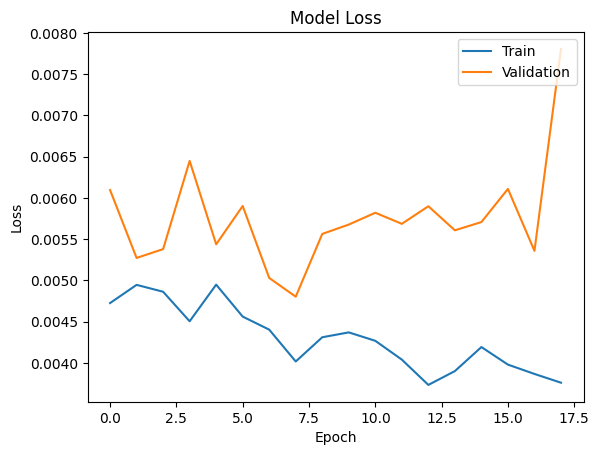

Mean Absolute Error 0.03869161796894174
Mean Squared Error 0.0029318196900847923
Root Mean Squared Error 0.05414628048245597


In [5]:

## Define callbacks

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model1.keras',
    monitor='val_loss',
    save_best_only=True,
    # save_weights_only=False,
    # mode='min'
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

predictions = model.predict(X_test)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 42, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,355 (860.77 KB)

 Trainable params: 73,451 (286.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,904 (573.85 KB)

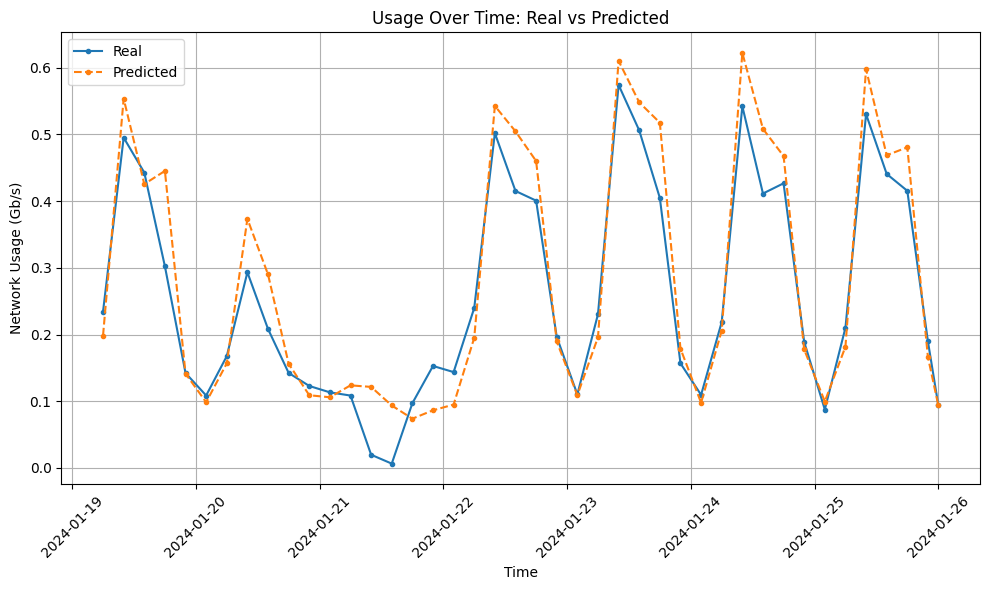

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-42:], y_test[-42:], label='Real', marker='.')
plt.plot(timestamps_test[-42:], predictions[-42:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

In [8]:
# Asumiendo que ya tienes un modelo entrenado y escalado, así como el último conjunto de secuencias X
# 'X_latest' es el último conjunto de datos de entrada de forma (1, n_steps, n_features)

X_latest = X_test[-1].reshape(1, n_steps, n_features)  # Asegúrate de que esto tenga la forma correcta

n_predictions = 10  # Número de predicciones futuras que quieres generar
predicted_future = []  # Para almacenar las predicciones
current_step = X_latest  # Iniciar con la última secuencia conocida

for _ in range(n_predictions):
    # Predecir el siguiente paso
    next_step_pred = model.predict(current_step)
    predicted_future.append(next_step_pred.flatten()[0])  # Almacenar la predicción
    
    # Actualizar la secuencia de entrada para la próxima predicción
    next_step_pred = next_step_pred.reshape(1, 1, n_features)  # Asegúrate de que esto tenga la forma correcta
    current_step = np.append(current_step[:, 1:, :], next_step_pred, axis=1)

# Si lo deseas, puedes invertir el escalado de tus predicciones aquí para transformarlas de vuelta a su escala original

# Visualizar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(range(len(predicted_future)), predicted_future, label='Predicted Future', marker='.')
plt.title('Future Predictions Beyond Actual Data')
plt.xlabel('Future Steps')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


ValueError: cannot reshape array of size 1 into shape (1,1,7)

In [9]:
# Asumiendo que ya tienes un modelo entrenado y escalado, así como el último conjunto de secuencias X
# 'X_latest' es el último conjunto de datos de entrada de forma (1, n_steps, n_features)

X_latest = X_test[-1].reshape(1, n_steps, n_features)  # Asegúrate de que esto tenga la forma correcta

n_predictions = 10  # Número de predicciones futuras que quieres generar
predicted_future = []  # Para almacenar las predicciones
current_step = X_latest  # Iniciar con la última secuencia conocida

for _ in range(n_predictions):
    # Predecir el siguiente paso
    next_step_pred = model.predict(current_step)
    predicted_future.append(next_step_pred.flatten()[0])  # Almacenar la predicción
    
    # Actualizar la secuencia de entrada para la próxima predicción
    next_step_pred = next_step_pred.reshape(1, 1, 1)  # Asegúrate de que esto tenga la forma correcta
    current_step = np.append(current_step[:, 1:, :], next_step_pred, axis=1)

# Si lo deseas, puedes invertir el escalado de tus predicciones aquí para transformarlas de vuelta a su escala original

# Visualizar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(range(len(predicted_future)), predicted_future, label='Predicted Future', marker='.')
plt.title('Future Predictions Beyond Actual Data')
plt.xlabel('Future Steps')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 1 has size 1

In [10]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    """
    Predict future steps beyond the actual data.

    Parameters:
    - model: The trained LSTM model.
    - last_sequence: The last known data sequence (the most recent sequence from X_test).
    - n_steps_into_future: Number of future steps to predict.

    Returns:
    - A list containing the future predictions.
    """
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        # Predict the next step
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        # Append the prediction
        future_predictions.append(next_step_pred.flatten()[0])
        # Update the sequence to include the new prediction
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

# Assuming X_test[-1] contains the most recent sequence of data
n_steps_into_future = 10  # For example, predict 10 steps into the future
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Visualize the future predictions
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, closed='right')
plt.figure(figsize=(10, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


TypeError: DatetimeArray._generate_range() got an unexpected keyword argument 'closed'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


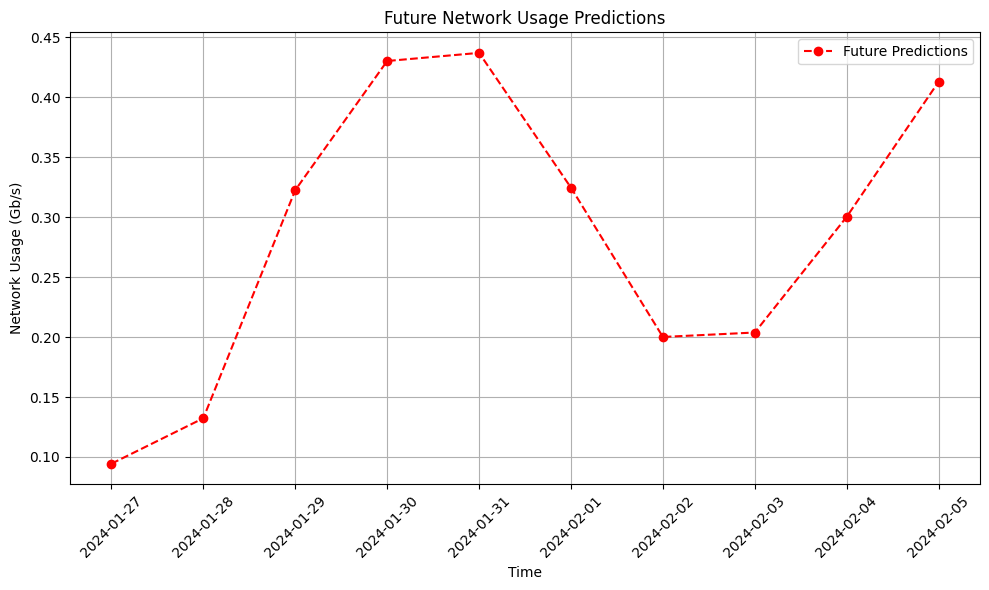

In [11]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 10
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='D')[1:]

plt.figure(figsize=(10, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

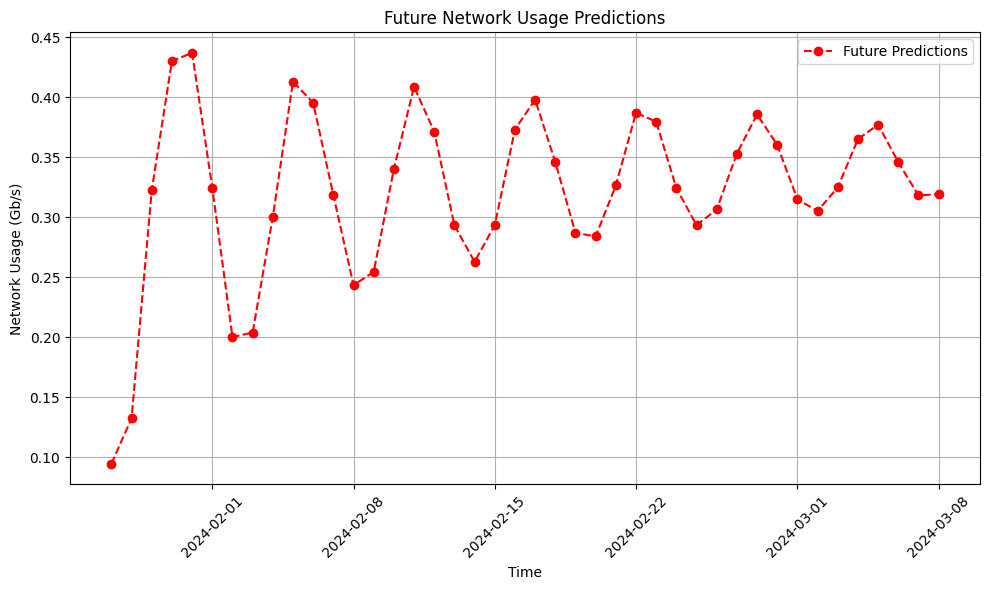

In [12]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 42
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='D')[1:]

plt.figure(figsize=(10, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

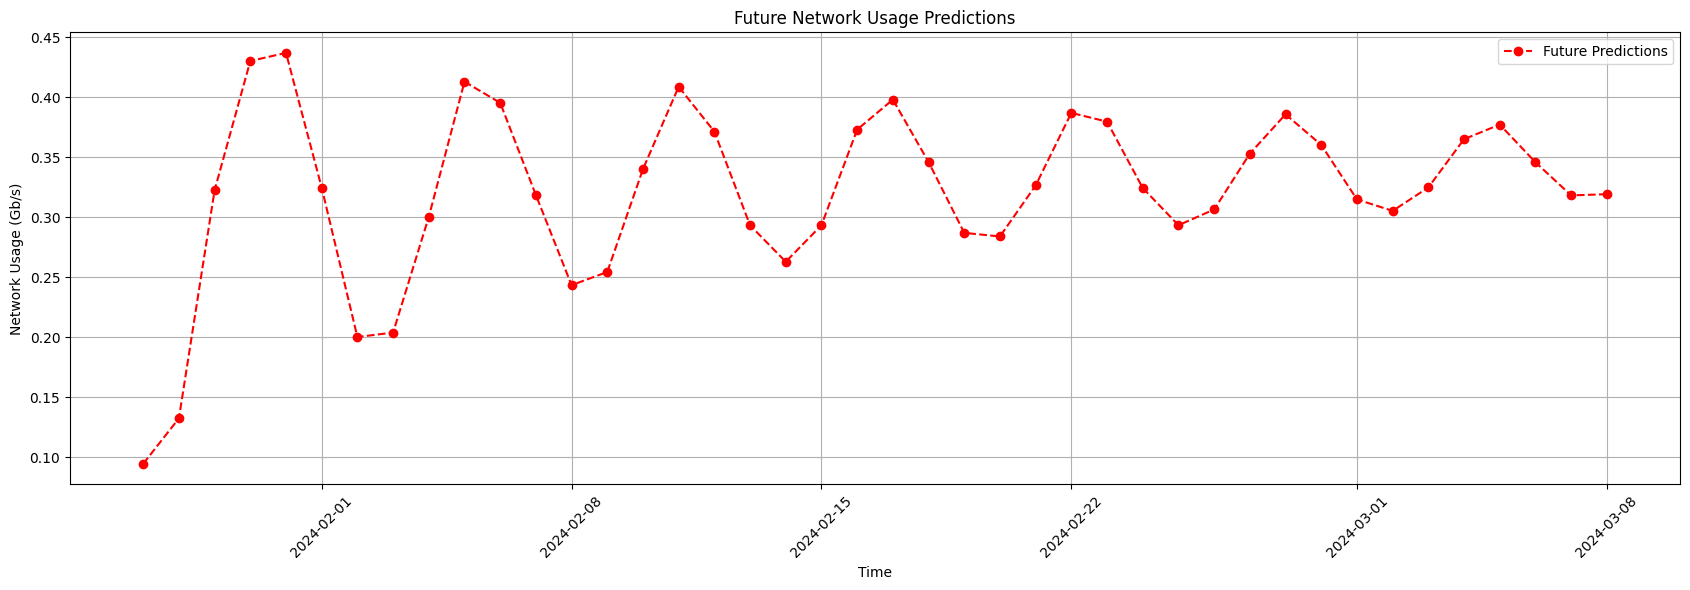

In [13]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 42
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='D')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<ipython-input-14-d38d9aabc7e1>:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4H')[1:]


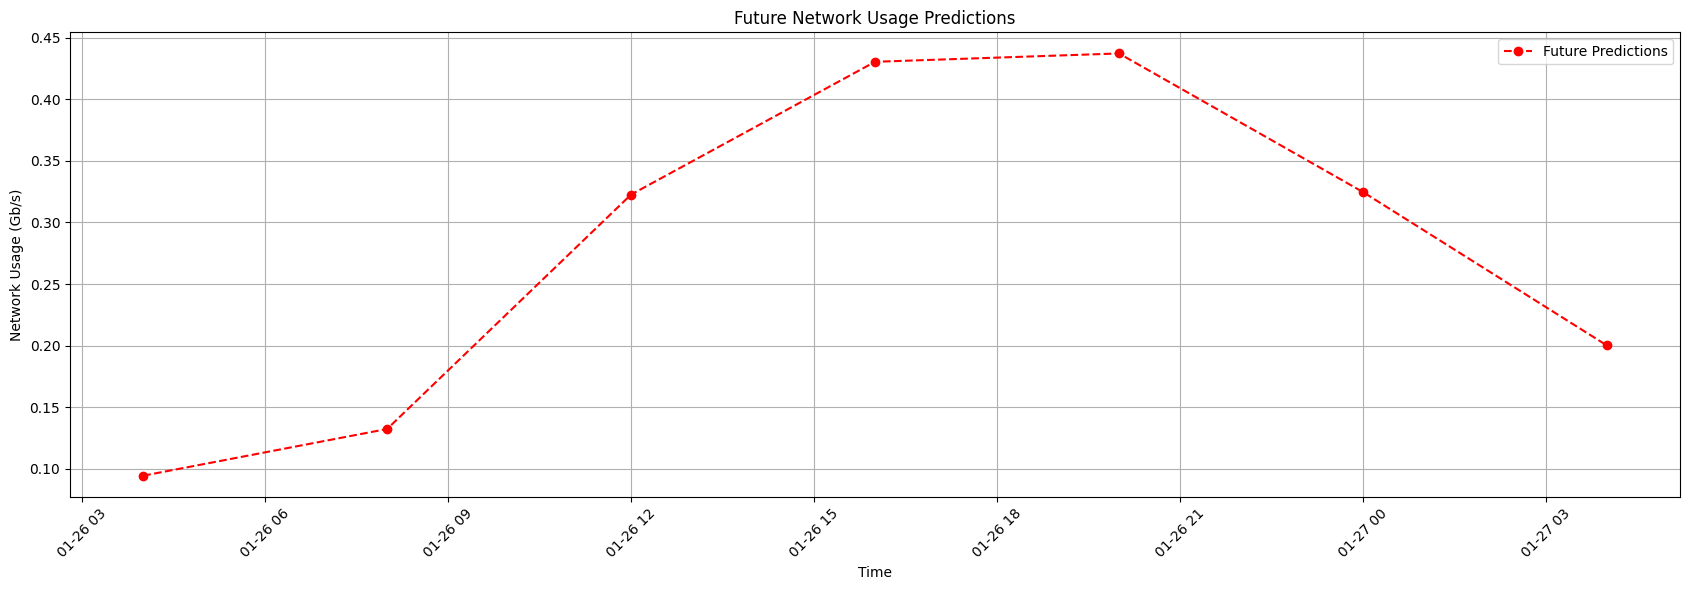

In [14]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 7
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4H')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


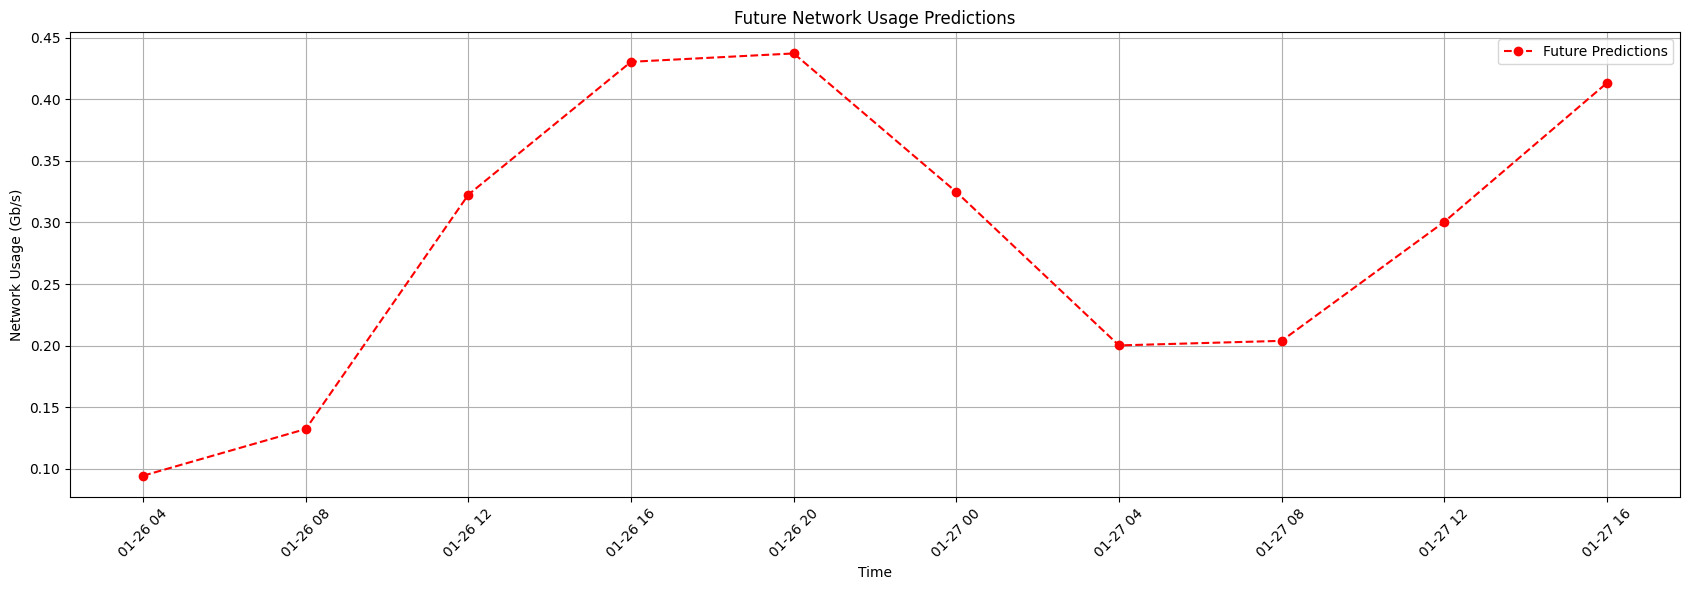

In [15]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 10
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
n_steps_into_future = 42

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='D')[1:]

In [17]:
future_timestamps

DatetimeIndex(['2024-01-27 00:00:00+00:00', '2024-01-28 00:00:00+00:00',
               '2024-01-29 00:00:00+00:00', '2024-01-30 00:00:00+00:00',
               '2024-01-31 00:00:00+00:00', '2024-02-01 00:00:00+00:00',
               '2024-02-02 00:00:00+00:00', '2024-02-03 00:00:00+00:00',
               '2024-02-04 00:00:00+00:00', '2024-02-05 00:00:00+00:00',
               '2024-02-06 00:00:00+00:00', '2024-02-07 00:00:00+00:00',
               '2024-02-08 00:00:00+00:00', '2024-02-09 00:00:00+00:00',
               '2024-02-10 00:00:00+00:00', '2024-02-11 00:00:00+00:00',
               '2024-02-12 00:00:00+00:00', '2024-02-13 00:00:00+00:00',
               '2024-02-14 00:00:00+00:00', '2024-02-15 00:00:00+00:00',
               '2024-02-16 00:00:00+00:00', '2024-02-17 00:00:00+00:00',
               '2024-02-18 00:00:00+00:00', '2024-02-19 00:00:00+00:00',
               '2024-02-20 00:00:00+00:00', '2024-02-21 00:00:00+00:00',
               '2024-02-22 00:00:00+00:00', '2024-0

In [18]:
n_steps_into_future = 42

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

In [19]:
future_timestamps

DatetimeIndex(['2024-01-26 04:00:00+00:00', '2024-01-26 08:00:00+00:00',
               '2024-01-26 12:00:00+00:00', '2024-01-26 16:00:00+00:00',
               '2024-01-26 20:00:00+00:00', '2024-01-27 00:00:00+00:00',
               '2024-01-27 04:00:00+00:00', '2024-01-27 08:00:00+00:00',
               '2024-01-27 12:00:00+00:00', '2024-01-27 16:00:00+00:00',
               '2024-01-27 20:00:00+00:00', '2024-01-28 00:00:00+00:00',
               '2024-01-28 04:00:00+00:00', '2024-01-28 08:00:00+00:00',
               '2024-01-28 12:00:00+00:00', '2024-01-28 16:00:00+00:00',
               '2024-01-28 20:00:00+00:00', '2024-01-29 00:00:00+00:00',
               '2024-01-29 04:00:00+00:00', '2024-01-29 08:00:00+00:00',
               '2024-01-29 12:00:00+00:00', '2024-01-29 16:00:00+00:00',
               '2024-01-29 20:00:00+00:00', '2024-01-30 00:00:00+00:00',
               '2024-01-30 04:00:00+00:00', '2024-01-30 08:00:00+00:00',
               '2024-01-30 12:00:00+00:00', '2024-0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

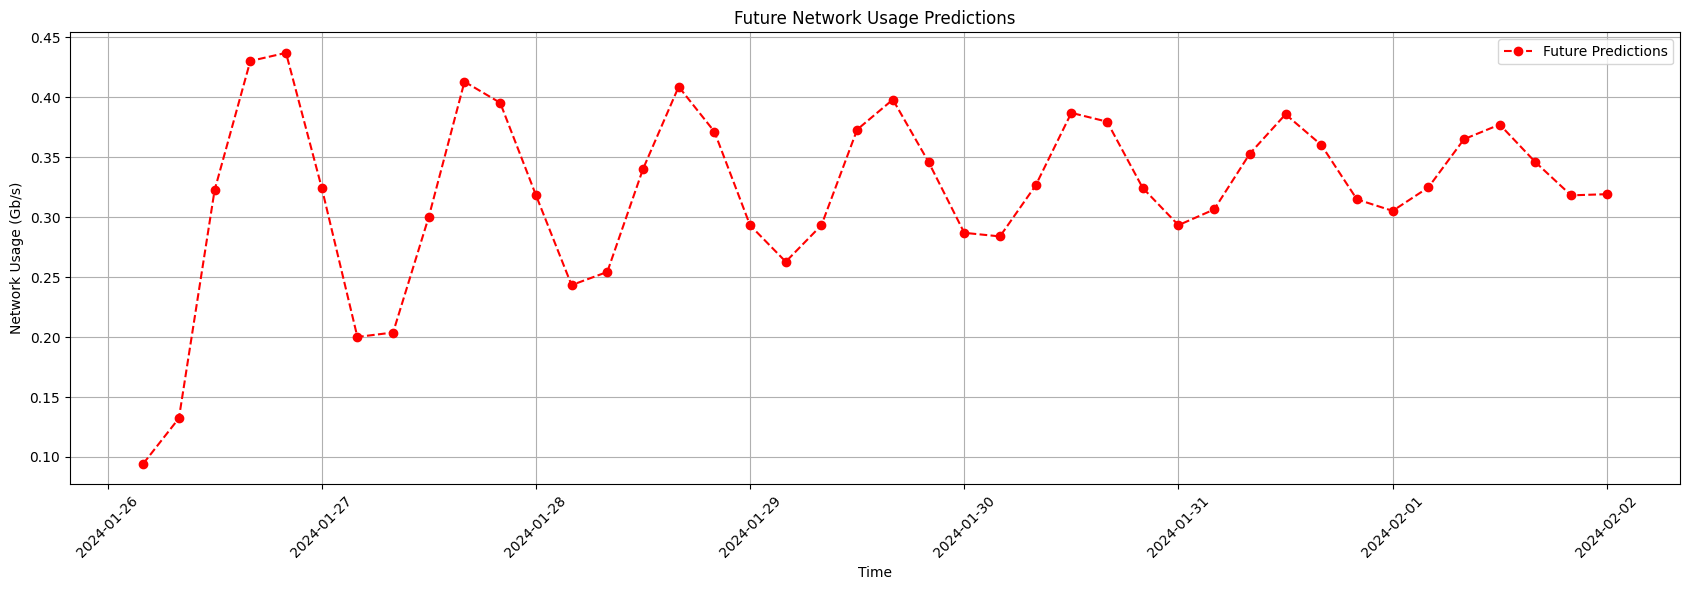

In [20]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 42
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


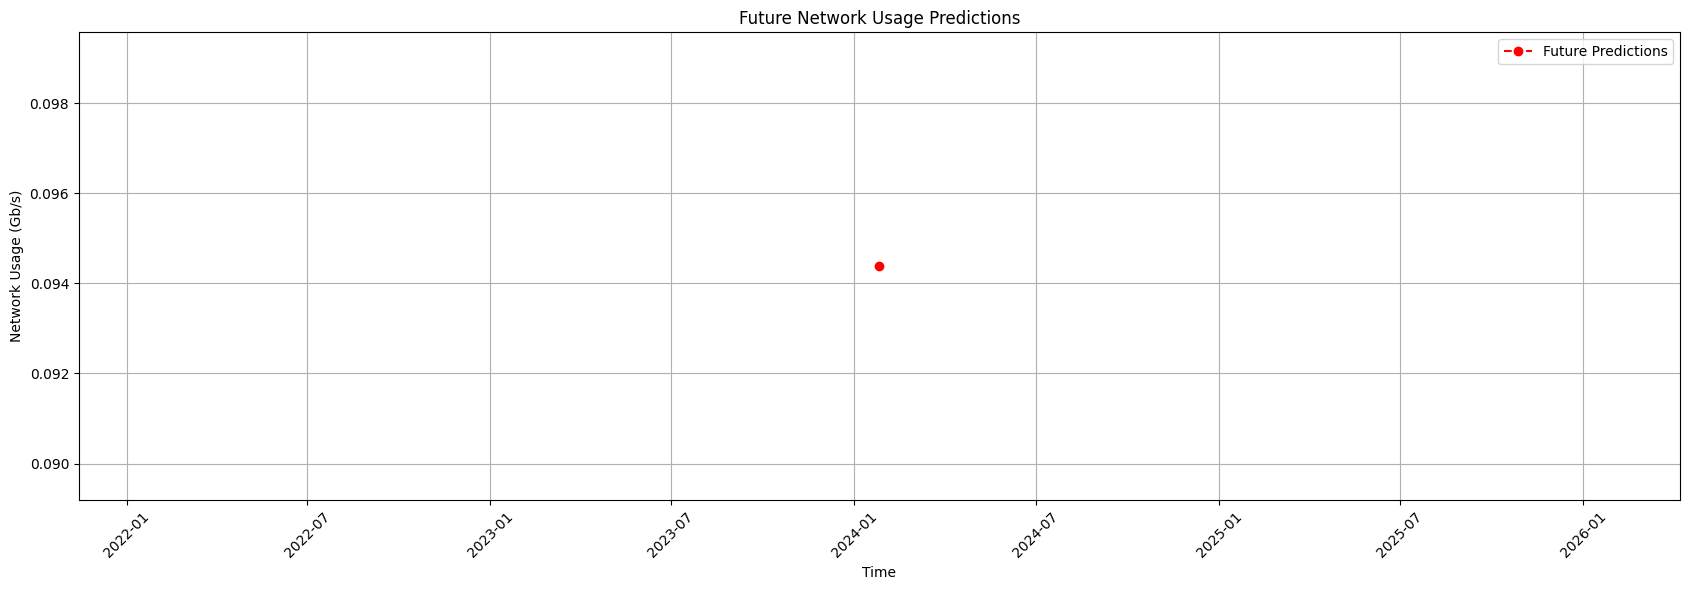

In [21]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 1
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


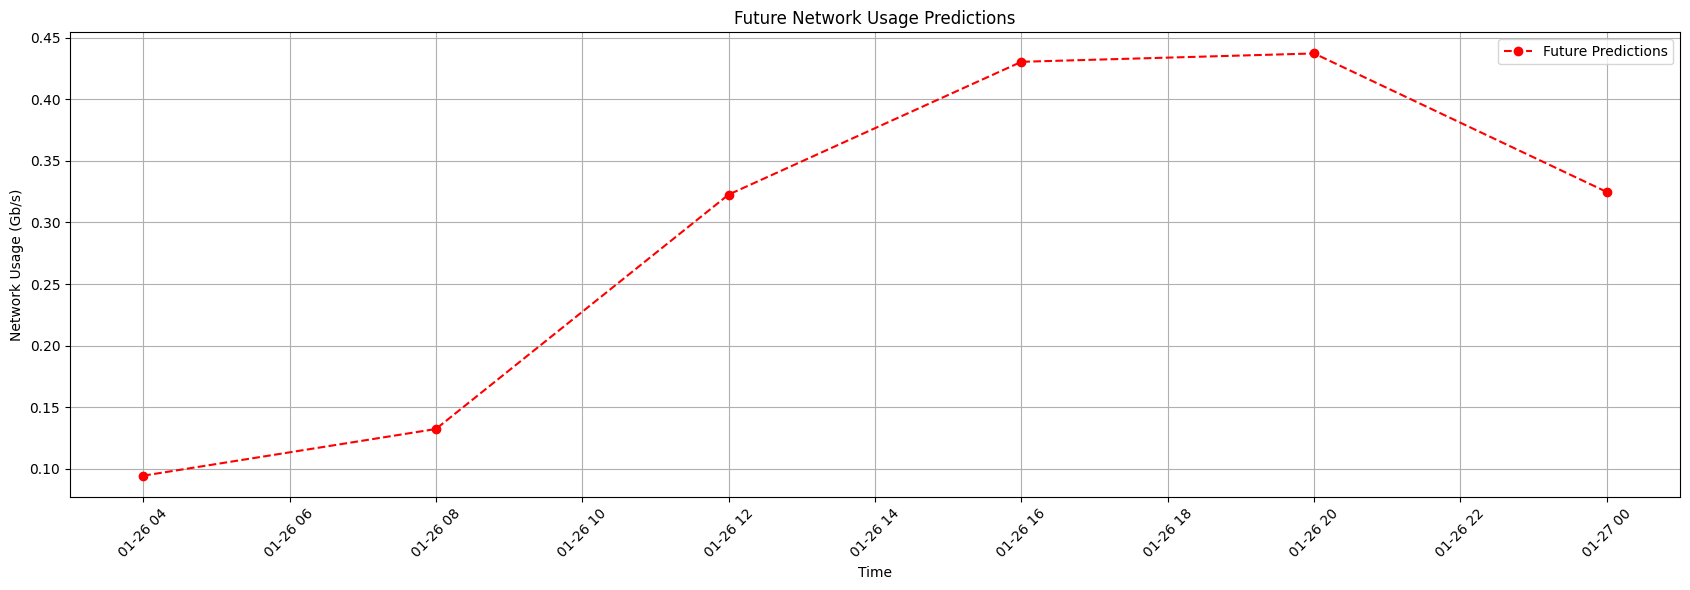

In [22]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 6
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


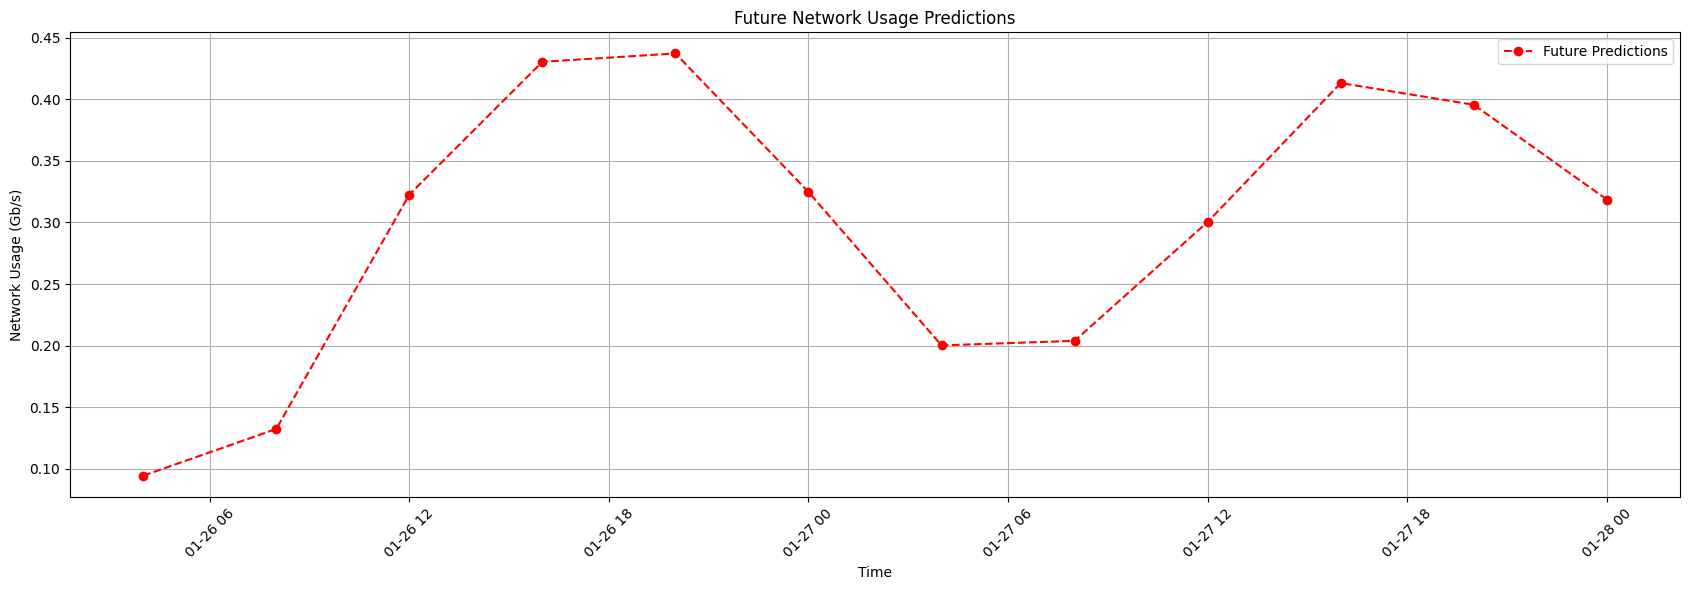

In [23]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 12
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


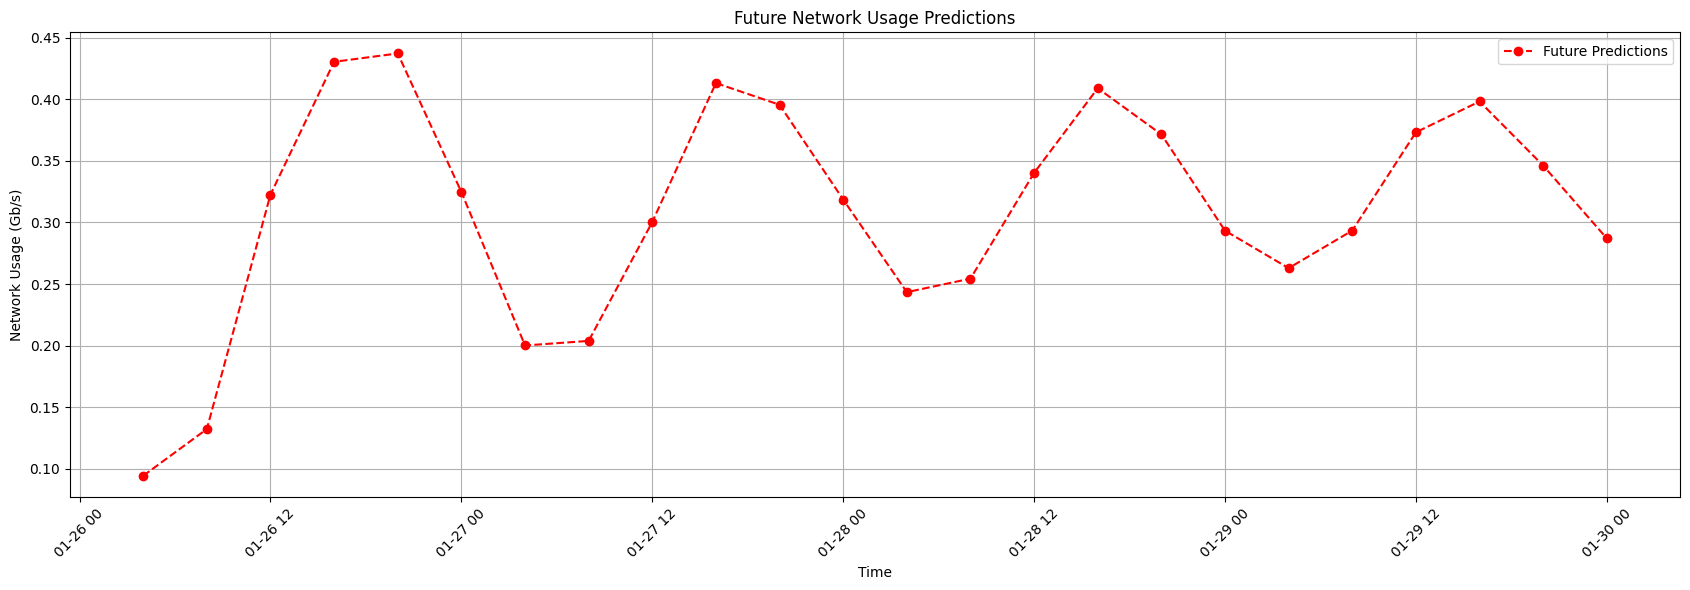

In [24]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 24
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
n_steps_into_future = 6

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

In [26]:
future_timestamps

DatetimeIndex(['2024-01-26 04:00:00+00:00', '2024-01-26 08:00:00+00:00',
               '2024-01-26 12:00:00+00:00', '2024-01-26 16:00:00+00:00',
               '2024-01-26 20:00:00+00:00', '2024-01-27 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='4h')

In [27]:
n_steps_into_future = 24

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

In [28]:
future_timestamps

DatetimeIndex(['2024-01-26 04:00:00+00:00', '2024-01-26 08:00:00+00:00',
               '2024-01-26 12:00:00+00:00', '2024-01-26 16:00:00+00:00',
               '2024-01-26 20:00:00+00:00', '2024-01-27 00:00:00+00:00',
               '2024-01-27 04:00:00+00:00', '2024-01-27 08:00:00+00:00',
               '2024-01-27 12:00:00+00:00', '2024-01-27 16:00:00+00:00',
               '2024-01-27 20:00:00+00:00', '2024-01-28 00:00:00+00:00',
               '2024-01-28 04:00:00+00:00', '2024-01-28 08:00:00+00:00',
               '2024-01-28 12:00:00+00:00', '2024-01-28 16:00:00+00:00',
               '2024-01-28 20:00:00+00:00', '2024-01-29 00:00:00+00:00',
               '2024-01-29 04:00:00+00:00', '2024-01-29 08:00:00+00:00',
               '2024-01-29 12:00:00+00:00', '2024-01-29 16:00:00+00:00',
               '2024-01-29 20:00:00+00:00', '2024-01-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='4h')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━

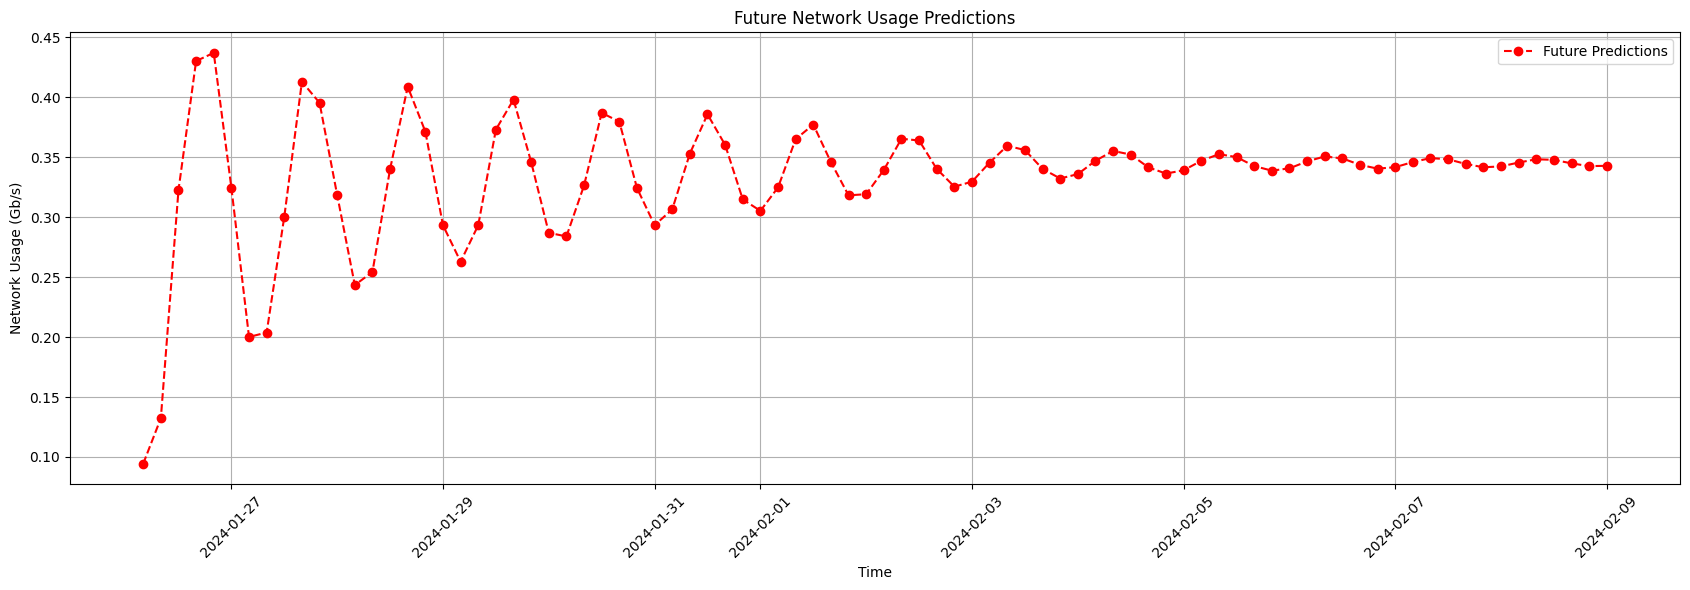

In [30]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 84
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

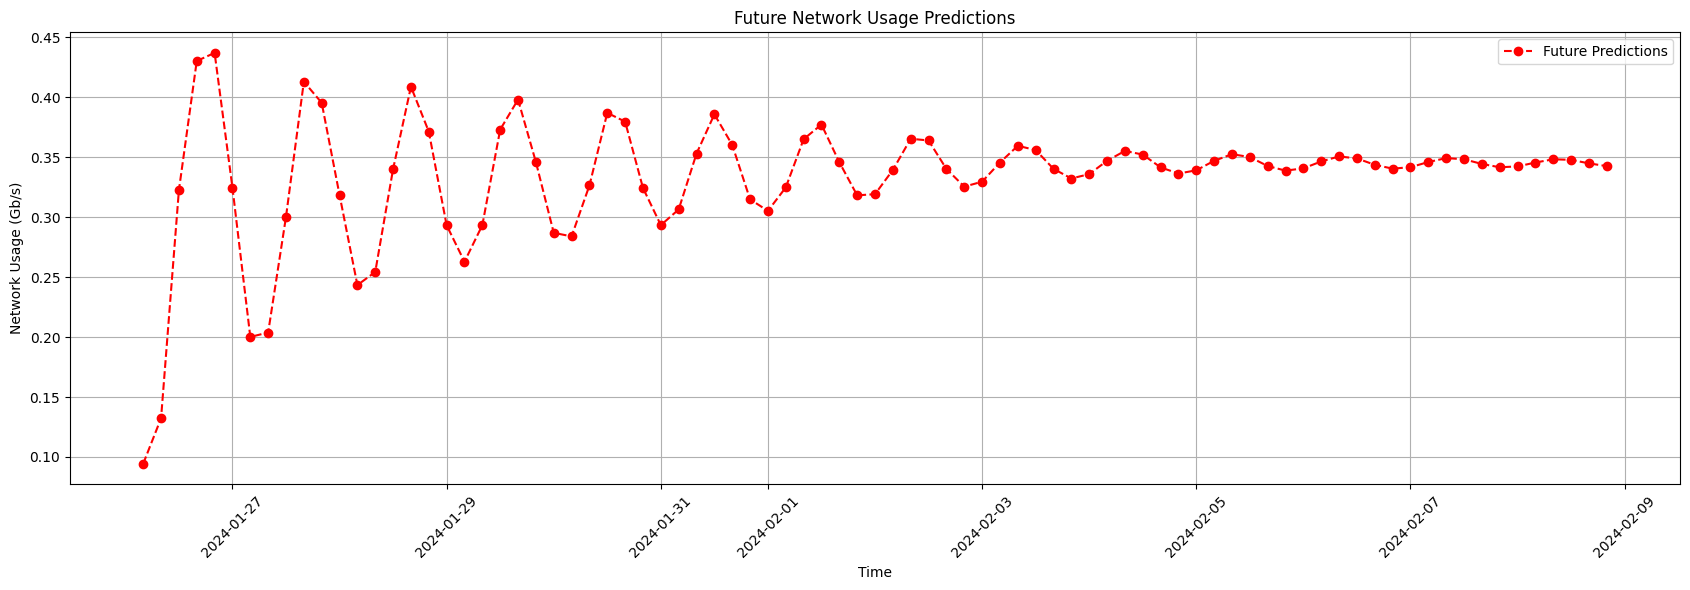

In [31]:
def predict_future_steps(model, last_sequence, n_steps_into_future):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_steps_into_future):
        next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_step_pred.flatten()[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step_pred

    return future_predictions

n_steps_into_future = 83
future_predictions = predict_future_steps(model, X_test[-1], n_steps_into_future)

# Genera marcas de tiempo futuras iniciando desde el día siguiente al último timestamp conocido
future_timestamps = pd.date_range(start=timestamps_test[-1], periods=n_steps_into_future + 1, freq='4h')[1:]

plt.figure(figsize=(17, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 42, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,355 (860.77 KB)

 Trainable params: 73,451 (286.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,904 (573.85 KB)

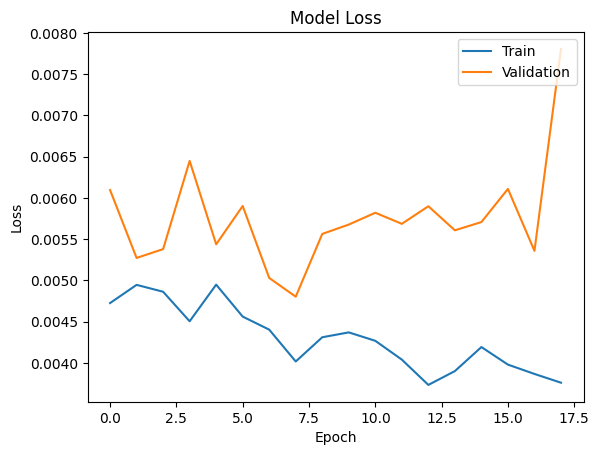

Mean Absolute Error 0.03869161796894174
Mean Squared Error 0.0029318196900847923
Root Mean Squared Error 0.05414628048245597


In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

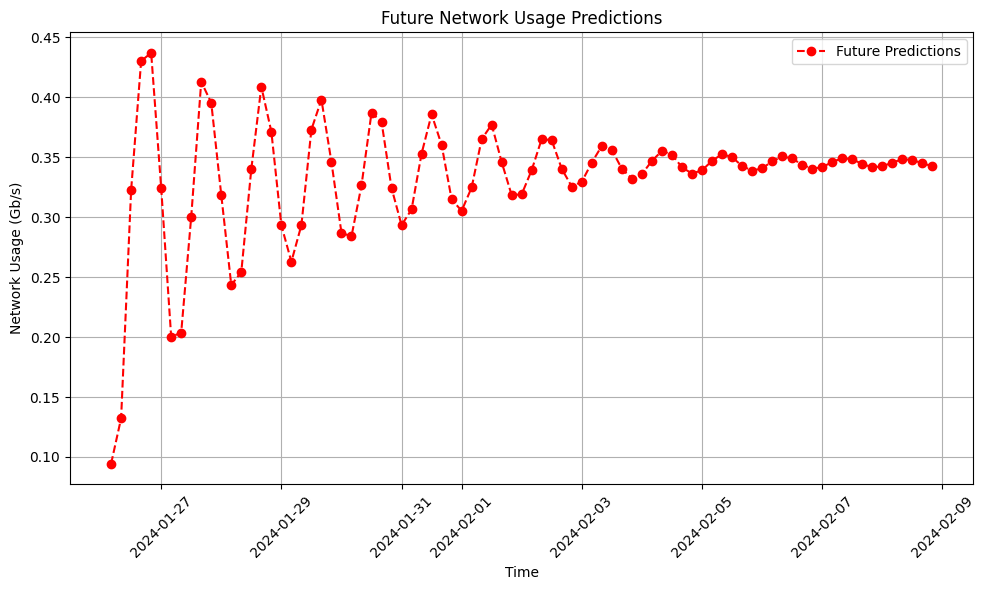

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(future_timestamps, future_predictions, label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
future_predictions

[0.09438136,
 0.13230197,
 0.32259429,
 0.43038458,
 0.43716753,
 0.3246935,
 0.20014659,
 0.20385014,
 0.30039224,
 0.4131254,
 0.3955145,
 0.3185796,
 0.24341553,
 0.2543903,
 0.3402163,
 0.40893912,
 0.37147135,
 0.29331324,
 0.26291668,
 0.2934046,
 0.37317264,
 0.3981918,
 0.34612012,
 0.28703326,
 0.2840336,
 0.3265512,
 0.38712192,
 0.37977242,
 0.32443786,
 0.293422,
 0.30652127,
 0.35310888,
 0.3859155,
 0.36039254,
 0.3149417,
 0.30534494,
 0.32488316,
 0.3651666,
 0.3773623,
 0.34596074,
 0.31829852,
 0.31926608,
 0.33948326,
 0.36551082,
 0.3640771,
 0.3403357,
 0.32554734,
 0.32968402,
 0.34569162,
 0.35963073,
 0.35610145,
 0.340415,
 0.33235025,
 0.33600128,
 0.3471167,
 0.35535872,
 0.3523122,
 0.34164554,
 0.33647376,
 0.33920038,
 0.34710458,
 0.35264283,
 0.3502255,
 0.34274495,
 0.33892074,
 0.34080565,
 0.34661257,
 0.35074723,
 0.34911436,
 0.34376794,
 0.34056824,
 0.34179124,
 0.34609598,
 0.34936613,
 0.34840798,
 0.34448028,
 0.3417305,
 0.34243128,
 0.3456787

In [36]:
future_timestamps

DatetimeIndex(['2024-01-26 04:00:00+00:00', '2024-01-26 08:00:00+00:00',
               '2024-01-26 12:00:00+00:00', '2024-01-26 16:00:00+00:00',
               '2024-01-26 20:00:00+00:00', '2024-01-27 00:00:00+00:00',
               '2024-01-27 04:00:00+00:00', '2024-01-27 08:00:00+00:00',
               '2024-01-27 12:00:00+00:00', '2024-01-27 16:00:00+00:00',
               '2024-01-27 20:00:00+00:00', '2024-01-28 00:00:00+00:00',
               '2024-01-28 04:00:00+00:00', '2024-01-28 08:00:00+00:00',
               '2024-01-28 12:00:00+00:00', '2024-01-28 16:00:00+00:00',
               '2024-01-28 20:00:00+00:00', '2024-01-29 00:00:00+00:00',
               '2024-01-29 04:00:00+00:00', '2024-01-29 08:00:00+00:00',
               '2024-01-29 12:00:00+00:00', '2024-01-29 16:00:00+00:00',
               '2024-01-29 20:00:00+00:00', '2024-01-30 00:00:00+00:00',
               '2024-01-30 04:00:00+00:00', '2024-01-30 08:00:00+00:00',
               '2024-01-30 12:00:00+00:00', '2024-0

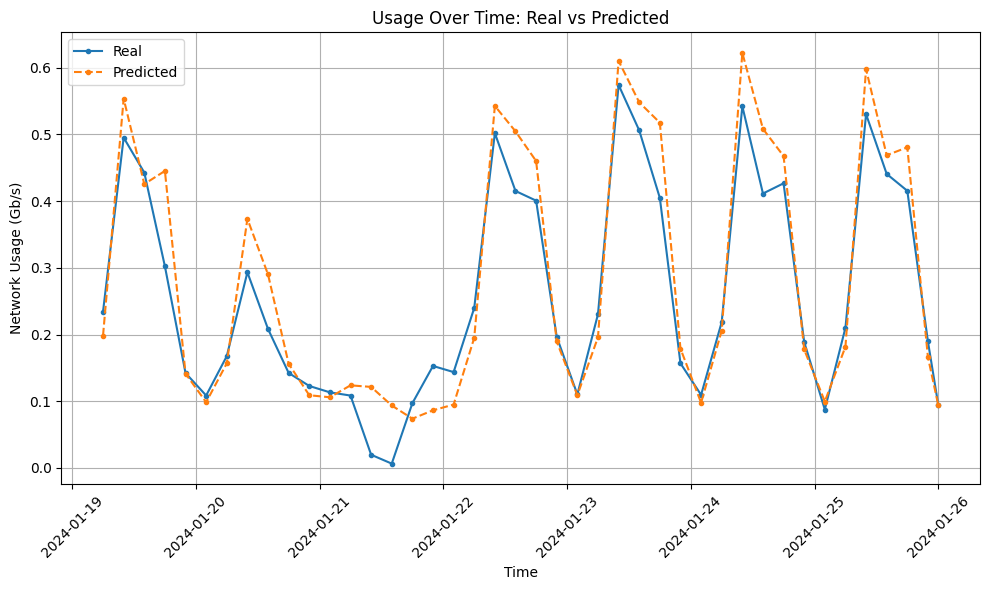

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-42:], y_test[-42:], label='Real', marker='.')
plt.plot(timestamps_test[-42:], predictions[-42:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

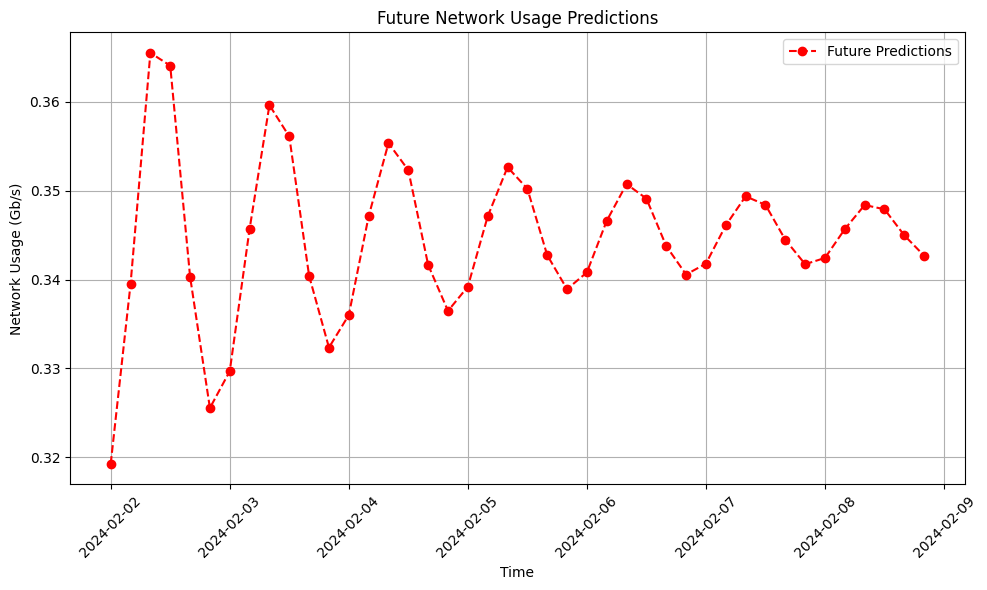

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(future_timestamps[-42:], future_predictions[-42:], label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

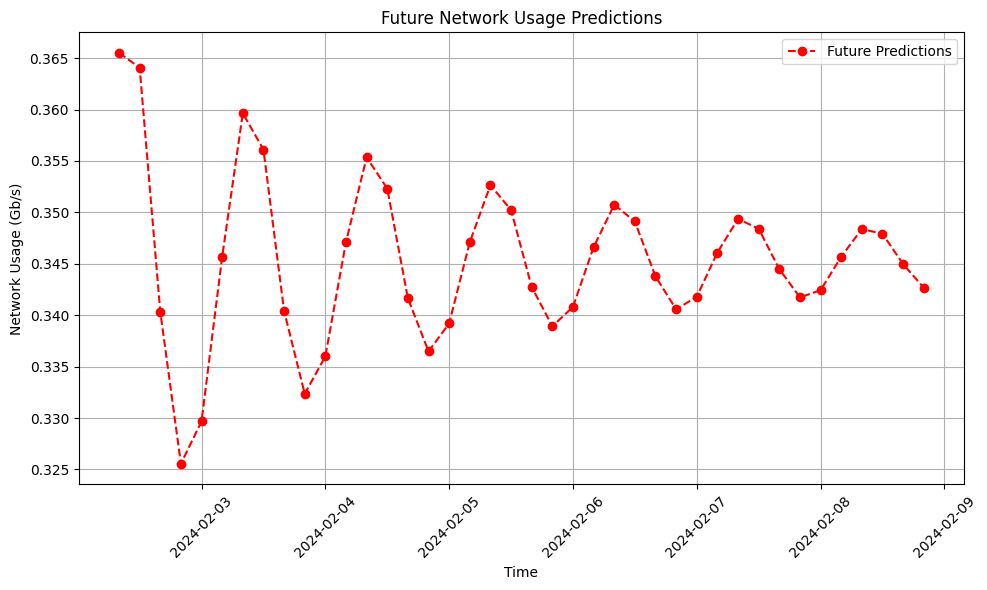

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(future_timestamps[-40:], future_predictions[-40:], label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

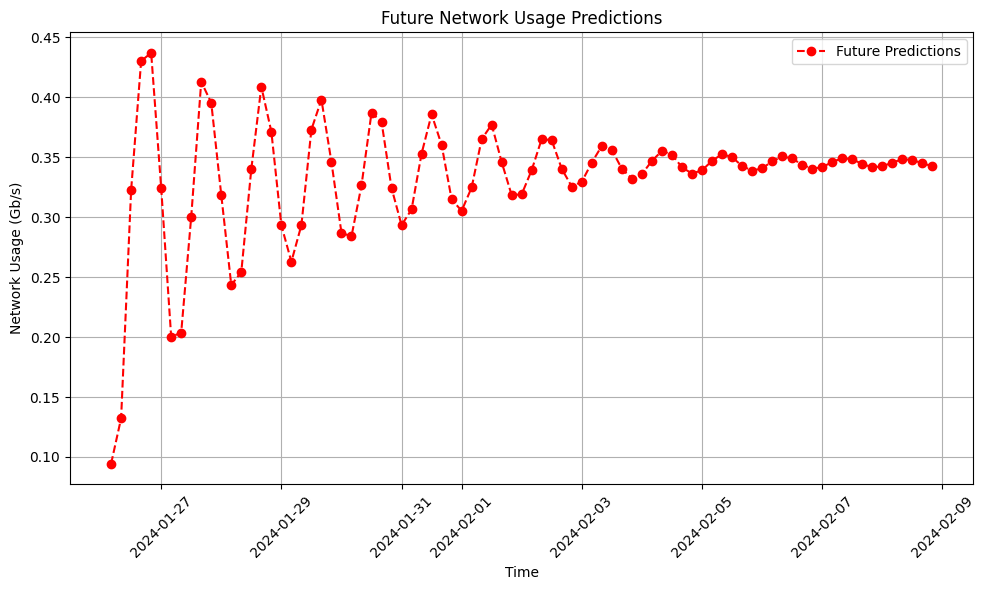

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(future_timestamps[-100:], future_predictions[-100:], label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

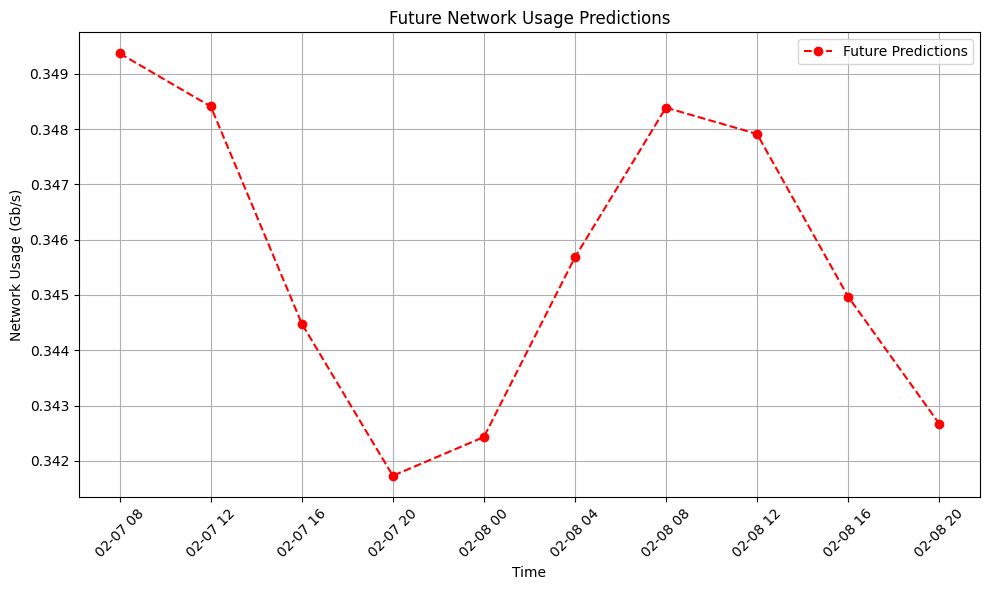

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(future_timestamps[-10:], future_predictions[-10:], label='Future Predictions', marker='o', linestyle='--', color='red')
plt.title('Future Network Usage Predictions')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()